### Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
sns.set_style("darkgrid", {"font.family": "Helvetica"})
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import plot_tree
from uszipcode import SearchEngine
import mpu
import zipcodes
import warnings
warnings.filterwarnings("ignore")

/Users/danielgieseke/anaconda3/envs/learn-env/lib/python3.8/site-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


### Loading Electric Vehicle (EV) Registration Data into Pandas Dataframes

In [2]:
# New York EV Registrations
df_ny = pd.read_csv('NY_EV_Registrations.csv')

df_ny.head()

,State,ZIP Code,Registration Date,Vehicle Make,Vehicle Model,Vehicle Model Year,Drivetrain Type,Vehicle GVWR Class,Vehicle Category,Vehicle Count,DMV Snapshot ID,DMV Snapshot (Date),Latest DMV Snapshot Flag
0,NY,10001,12/1/2018,TESLA,MODEL 3,2018.0,BEV,1,Light-Duty (Class 1-2A),1,31,DMV Snapshot (10/11/2019),False
1,NY,14425,12/1/2018,TESLA,MODEL 3,2018.0,BEV,1,Light-Duty (Class 1-2A),1,31,DMV Snapshot (10/11/2019),False
2,NY,13851,12/1/2018,TESLA,MODEL 3,2018.0,BEV,1,Light-Duty (Class 1-2A),1,31,DMV Snapshot (10/11/2019),False
3,NY,12308,12/1/2018,TESLA,MODEL 3,2018.0,BEV,1,Light-Duty (Class 1-2A),1,31,DMV Snapshot (10/11/2019),False
4,NY,14031,12/1/2018,TESLA,MODEL 3,2018.0,BEV,1,Light-Duty (Class 1-2A),1,31,DMV Snapshot (10/11/2019),False


In [3]:
# Limiting NY dataframe to the DMV Snapshot from 1/1/2022
df_ny = df_ny.loc[(df_ny['DMV Snapshot (Date)'] == 'DMV Snapshot (1/1/2022)')]

In [4]:
# New Jersey EV Registrations
df_nj = pd.read_csv('NJ_EV_Registrations.csv')

df_nj.head()

,State,ZIP Code,Registration Date,Vehicle Make,Vehicle Model,Vehicle Model Year,Drivetrain Type,Vehicle GVWR Class,Vehicle Category,Vehicle Count,DMV Snapshot ID,DMV Snapshot (Date),Latest DMV Snapshot Flag
0,NJ,08858,12/1/2017,TESLA,MODEL S,2015,BEV,1,Light-Duty (Class 1-2A),1,3,DMV Snapshot (12/31/2017),False
1,NJ,07722,12/1/2017,TESLA,MODEL S,2015,BEV,1,Light-Duty (Class 1-2A),1,3,DMV Snapshot (12/31/2017),False
2,NJ,07463,12/1/2017,TESLA,MODEL S,2015,BEV,1,Light-Duty (Class 1-2A),1,3,DMV Snapshot (12/31/2017),False
3,NJ,08096,12/1/2017,TESLA,MODEL S,2015,BEV,1,Light-Duty (Class 1-2A),1,3,DMV Snapshot (12/31/2017),False
4,NJ,08902,12/1/2017,TESLA,MODEL S,2015,BEV,1,Light-Duty (Class 1-2A),1,3,DMV Snapshot (12/31/2017),False


In [5]:
# Limiting NJ dataframe to the DMV Snapshot from 12/31/2021
df_nj = df_nj.loc[(df_nj['DMV Snapshot (Date)'] == 'DMV Snapshot (12/31/2021)')]

### Grouping Each Dataframe by Zip Code

In [6]:
# New Jersey Grouped Dataframe
df_nj = df_nj[['ZIP Code', 'Vehicle Count']]
df_nj = df_nj.groupby(['ZIP Code']).sum()
df_nj['NJ'] = 1
df_nj.head()

,Vehicle Count,NJ
ZIP Code,,
01070,1,1
01757,2,1
01966,1,1
02141,1,1
02142,1,1


In [7]:
df_nj = df_nj.reset_index()

In [8]:
# Ensuring Dataframe only includes zip codes in New Jersey
zips = df_nj['ZIP Code']
valid = []

for code in zips:
    if code == 'Error':
        valid.append(0)
    else:
        state = zipcodes.matching(code)[0]['state']
        if state == 'NJ':
            valid.append(1)
        else:
            valid.append(0)

df_nj['valid'] = valid
df_nj = df_nj.loc[(df_nj['valid'] == 1)]
df_nj = df_nj.drop(columns='valid')

In [9]:
df_nj.head()

,ZIP Code,Vehicle Count,NJ
12,07001,53,1
13,07002,181,1
14,07003,290,1
15,07004,97,1
16,07005,153,1


In [10]:
# New York Grouped Dataframe
df_ny['ZIP Code'] = df_ny['ZIP Code'].astype(str)
df_ny = df_ny[['ZIP Code', 'Vehicle Count']]
df_ny = df_ny.groupby(['ZIP Code']).sum()
df_ny['NY'] = 1
df_ny.head()

,Vehicle Count,NY
ZIP Code,,
00646,1,1
01254,1,1
01545,1,1
01583,1,1
01606,1,1


In [11]:
df_ny = df_ny.reset_index()

In [12]:
# Ensuring Dataframe only includes zip codes in New York
zips = list(df_ny['ZIP Code'])
valid = []

for code in zips:
    if code == 'Error':
        valid.append(0)
    elif len(code) < 5:
        valid.append(0)
    else:
        state = zipcodes.matching(code)[0]['state']
        if state == 'NY':
            valid.append(1)
        else:
            valid.append(0)

df_ny['valid'] = valid
df_ny = df_ny.loc[(df_ny['valid'] == 1)]
df_ny = df_ny.drop(columns='valid')

In [13]:
df_ny.head()

,ZIP Code,Vehicle Count,NY
30,06390,4,1
117,10001,113,1
118,10002,125,1
119,10003,208,1
120,10004,99,1


### Importing Income Information for Tri-State Area
Source: https://data.census.gov/

In [14]:
df_income = pd.read_csv('Income Data/ACSST5Y2021.S1903-Data.csv')

In [15]:
# Column 'S1903_C03_015E' gives an estimate of median family household income--which I believe will be an 
# important variable
df_income = df_income[['NAME', 'S1903_C03_015E']]

In [16]:
# Dropping first row which includes meta data
df_income = df_income.drop(index=0)
df_income.head()

,NAME,S1903_C03_015E
1,ZCTA5 06001,166235
2,ZCTA5 06002,97917
3,ZCTA5 06010,91605
4,ZCTA5 06013,156442
5,ZCTA5 06016,118345


In [17]:
# renaming columns
df_income = df_income.rename(columns={'NAME': 'ZIP Code', 'S1903_C03_015E': 'Median Family Household Income'})

In [18]:
# dropping unwanted strings and rows from zip code and median income columns
df_income['ZIP Code'] = df_income['ZIP Code'].str.replace(r'ZCTA5 ', '', regex=True)
df_income['Median Family Household Income'] = df_income['Median Family Household Income'].str.replace('+', '')
df_income['Median Family Household Income'] = df_income['Median Family Household Income'].str.replace(',', '')
df_income = df_income[df_income['Median Family Household Income'].str.contains('-')==False]

In [19]:
# Changing type of Income Column
df_income['Median Family Household Income'] = df_income['Median Family Household Income'].astype('int')

In [20]:
df_income.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2442 entries, 1 to 2712
Data columns (total 2 columns):
 #   Column                          Non-Null Count  Dtype 
---  ------                          --------------  ----- 
 0   ZIP Code                        2442 non-null   object
 1   Median Family Household Income  2442 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 57.2+ KB


### Importing Population Information for Tri-State Area
Source: https://data.census.gov/

In [21]:
df_pop = pd.read_csv('Population Data/DECENNIALDHC2020.P1-Data.csv')

In [22]:
df_pop.head()

,GEO_ID,NAME,P1_001N,P1_001NA,Unnamed: 4
0,Geography,Geographic Area Name,!!Total,Annotation of !!Total,NaN
1,860Z200US06001,ZCTA5 06001,19262,NaN,NaN
2,860Z200US06002,ZCTA5 06002,21579,NaN,NaN
3,860Z200US06010,ZCTA5 06010,60748,NaN,NaN
4,860Z200US06013,ZCTA5 06013,9519,NaN,NaN


In [23]:
# Limiting DF to relevant columns
df_pop = df_pop[['NAME', 'P1_001N']]

In [24]:
# Dropping first row which includes meta data
df_pop = df_pop.drop(index=0)

In [25]:
# renaming columns
df_pop = df_pop.rename(columns={'NAME': 'ZIP Code', 'P1_001N': 'Population'})

In [26]:
# dropping unwanted strings and rows from zip code and median income columns
df_pop['ZIP Code'] = df_pop['ZIP Code'].str.replace(r'ZCTA5 ', '', regex=True)

In [27]:
# Changing type of Population Column
df_pop['Population'] = df_pop['Population'].astype('int')

In [28]:
df_pop.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2712 entries, 1 to 2712
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   ZIP Code    2712 non-null   object
 1   Population  2712 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 42.5+ KB


### Importing Education Information for Tri-State Area
Source: https://data.census.gov/

In [29]:
df_ed = pd.read_csv('Education Data/ACSST5Y2021.S1501-Data.csv')

In [30]:
df_ed.head()

,GEO_ID,NAME,S1501_C01_001E,S1501_C01_001M,S1501_C01_001MA,S1501_C01_001EA,S1501_C01_002E,S1501_C01_002M,S1501_C01_002MA,S1501_C01_002EA,...,S1501_C06_062EA,S1501_C06_063E,S1501_C06_063EA,S1501_C06_063M,S1501_C06_063MA,S1501_C06_064E,S1501_C06_064EA,S1501_C06_064M,S1501_C06_064MA,Unnamed: 1538
0,Geography,Geographic Area Name,Estimate!!Total!!AGE BY EDUCATIONAL ATTAINMENT...,Margin of Error!!Total!!AGE BY EDUCATIONAL ATT...,Annotation of Margin of Error!!Total!!AGE BY E...,Annotation of Estimate!!Total!!AGE BY EDUCATIO...,Estimate!!Total!!AGE BY EDUCATIONAL ATTAINMENT...,Margin of Error!!Total!!AGE BY EDUCATIONAL ATT...,Annotation of Margin of Error!!Total!!AGE BY E...,Annotation of Estimate!!Total!!AGE BY EDUCATIO...,...,Annotation of Estimate!!Percent Female!!MEDIAN...,Estimate!!Percent Female!!MEDIAN EARNINGS IN T...,Annotation of Estimate!!Percent Female!!MEDIAN...,Margin of Error!!Percent Female!!MEDIAN EARNIN...,Annotation of Margin of Error!!Percent Female!...,Estimate!!Percent Female!!MEDIAN EARNINGS IN T...,Annotation of Estimate!!Percent Female!!MEDIAN...,Margin of Error!!Percent Female!!MEDIAN EARNIN...,Annotation of Margin of Error!!Percent Female!...,NaN
1,860Z200US06001,ZCTA5 06001,975,271,NaN,NaN,80,60,NaN,NaN,...,(X),(X),(X),(X),(X),(X),(X),(X),(X),NaN
2,860Z200US06002,ZCTA5 06002,1376,380,NaN,NaN,226,158,NaN,NaN,...,(X),(X),(X),(X),(X),(X),(X),(X),(X),NaN
3,860Z200US06010,ZCTA5 06010,4802,544,NaN,NaN,666,194,NaN,NaN,...,(X),(X),(X),(X),(X),(X),(X),(X),(X),NaN
4,860Z200US06013,ZCTA5 06013,522,156,NaN,NaN,28,28,NaN,NaN,...,(X),(X),(X),(X),(X),(X),(X),(X),(X),NaN


In [31]:
# Limiting DF to relevant columns
df_ed = df_ed[['NAME', 'S1501_C02_021E', 'S1501_C01_021E']]

In [32]:
# Dropping first row which includes meta data
df_ed = df_ed.drop(index=0)

In [33]:
# renaming columns per data dictionary - making education columns more readable
df_ed = df_ed.rename(columns={'NAME': 'ZIP Code', 'S1501_C02_021E': 'Percent Pop. Bachelors Deg. - 35-44', 
                              'S1501_C01_021E': 'Total Pop. Bachelors Deg. - 35-44'})

In [34]:
# dropping unwanted strings and rows from zip code
df_ed['ZIP Code'] = df_ed['ZIP Code'].str.replace(r'ZCTA5 ', '', regex=True)
df_ed = df_ed[df_ed['Percent Pop. Bachelors Deg. - 35-44'].str.contains('-')==False]

In [35]:
# Changing type of Educational Attainment Columns
df_ed['Percent Pop. Bachelors Deg. - 35-44'] = df_ed['Percent Pop. Bachelors Deg. - 35-44'].astype('float')
df_ed['Total Pop. Bachelors Deg. - 35-44'] = df_ed['Total Pop. Bachelors Deg. - 35-44'].astype('int')

In [36]:
# Inspecting final df_ed
df_ed.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2509 entries, 1 to 2712
Data columns (total 3 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   ZIP Code                             2509 non-null   object 
 1   Percent Pop. Bachelors Deg. - 35-44  2509 non-null   float64
 2   Total Pop. Bachelors Deg. - 35-44    2509 non-null   int64  
dtypes: float64(1), int64(1), object(1)
memory usage: 78.4+ KB


### Joining all EV Registration, Population, Income, and Education Dataframes

In [38]:
df_tri = pd.concat([df_ny, df_nj])

In [39]:
df_tri = df_tri.groupby(['ZIP Code']).sum()

In [40]:
df_tri.reset_index(inplace=True)

In [41]:
df_tri

,ZIP Code,Vehicle Count,NY,NJ
0,06390,4,1.0,0.0
1,07001,53,0.0,1.0
2,07002,181,0.0,1.0
3,07003,290,0.0,1.0
4,07004,97,0.0,1.0
...,...,...,...,...
2320,14898,1,1.0,0.0
2321,14901,17,1.0,0.0
2322,14903,28,1.0,0.0
2323,14904,13,1.0,0.0


In [42]:
df_tri = df_tri.merge(df_income, on='ZIP Code', how='left')

In [43]:
df_tri = df_tri.merge(df_pop, on='ZIP Code', how='left')

In [44]:
df_tri = df_tri.merge(df_ed, on='ZIP Code', how='left')

In [49]:
df_tri['NY'] = df_tri['NY'].fillna(0)
df_tri['NJ'] = df_tri['NJ'].fillna(0)

In [50]:
df_tri = df_tri.dropna(subset=['Population'])

In [51]:
df_tri = df_tri.dropna(subset=['Percent Pop. Bachelors Deg. - 35-44'])

In [52]:
df_tri = df_tri.dropna(subset=['Total Pop. Bachelors Deg. - 35-44'])

In [53]:
df_tri = df_tri.dropna(subset=['Median Family Household Income'])

In [54]:
df_tri.head()

,ZIP Code,Vehicle Count,NY,NJ,Median Family Household Income,Population,Percent Pop. Bachelors Deg. - 35-44,Total Pop. Bachelors Deg. - 35-44,EVs per capita
0,06390,4,1.0,0.0,46250.0,422.0,0.0,0.0,947.867299
1,07001,53,0.0,1.0,89079.0,16920.0,47.6,1093.0,313.238771
2,07002,181,0.0,1.0,84290.0,71686.0,46.8,4795.0,252.490026
3,07003,290,0.0,1.0,105720.0,52955.0,58.4,4708.0,547.634784
4,07004,97,0.0,1.0,133994.0,7872.0,83.3,872.0,1232.215447


In [55]:
df_tri['EVs per capita'] = (df_tri['Vehicle Count']/df_tri['Population'])*100000

In [56]:
df_tri

,ZIP Code,Vehicle Count,NY,NJ,Median Family Household Income,Population,Percent Pop. Bachelors Deg. - 35-44,Total Pop. Bachelors Deg. - 35-44,EVs per capita
0,06390,4,1.0,0.0,46250.0,422.0,0.0,0.0,947.867299
1,07001,53,0.0,1.0,89079.0,16920.0,47.6,1093.0,313.238771
2,07002,181,0.0,1.0,84290.0,71686.0,46.8,4795.0,252.490026
3,07003,290,0.0,1.0,105720.0,52955.0,58.4,4708.0,547.634784
4,07004,97,0.0,1.0,133994.0,7872.0,83.3,872.0,1232.215447
...,...,...,...,...,...,...,...,...,...
2320,14898,1,1.0,0.0,51923.0,1573.0,14.8,32.0,63.572791
2321,14901,17,1.0,0.0,45179.0,14893.0,13.3,285.0,114.147586
2322,14903,28,1.0,0.0,78329.0,7279.0,25.2,202.0,384.668224
2323,14904,13,1.0,0.0,63986.0,15102.0,16.6,309.0,86.081314


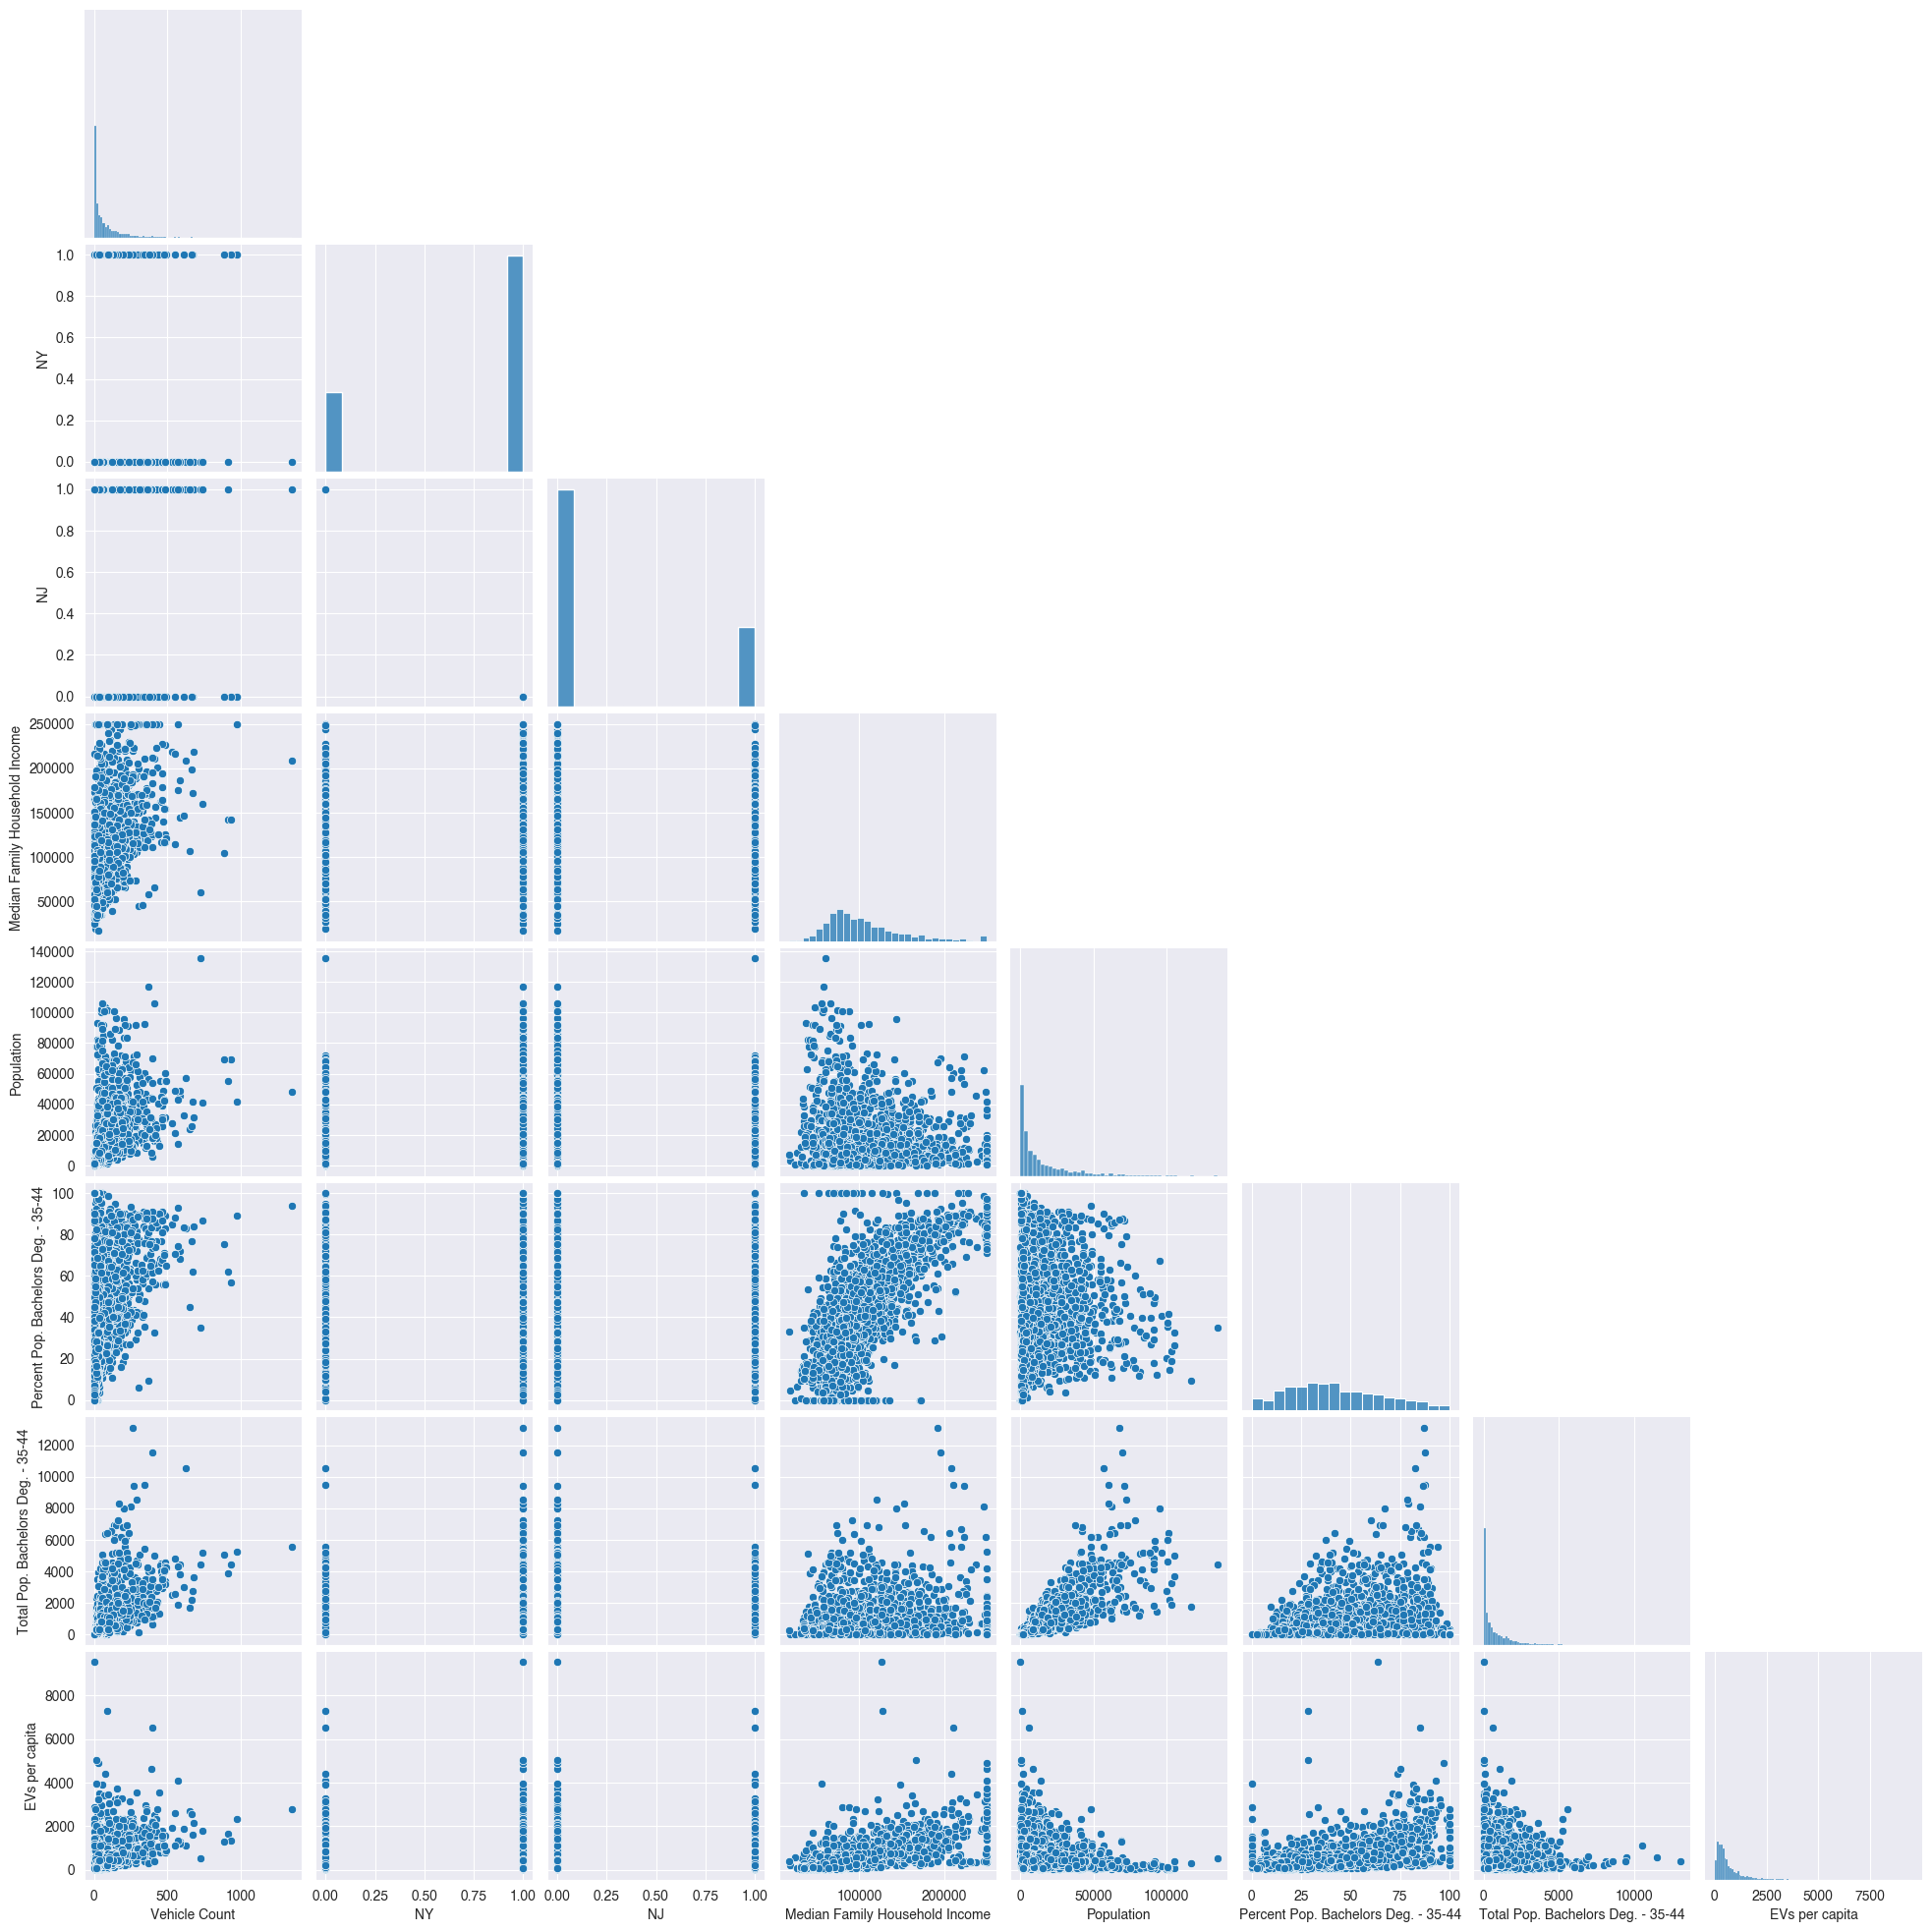

In [57]:
sns.pairplot(df_tri, corner=True);

### NYC Zip Codes
Data Source: https://namecensus.com/zip-codes/new-york/city/new-york/

In [58]:
df_nyc = pd.read_csv('NYC Zip Codes.csv')

In [59]:
# Creating loop for a boolean indicating if ZIP Code is in NYC
nyc_zips = list(df_nyc['ZIP Code'])
all_zips = df_tri['ZIP Code']

In [60]:
in_NYC = []

for zip_ in all_zips:
    if zip_ in nyc_zips:
        in_NYC.append(1)
    else:
        in_NYC.append(0)

In [61]:
df_tri['in_NYC'] = in_NYC

### Creating Variables for Distance from NYC

In [62]:
zips = df_tri['ZIP Code']
dist_NYC = []

for code in zips:
    search = SearchEngine()
    
    zip_NYC = search.by_zipcode('10001')
    lat_NYC = zip_NYC.lat
    long_NYC = zip_NYC.lng
    
    zip2 = search.by_zipcode(code)
    lat2 = zip2.lat
    long2 = zip2.lng
    
    dist = mpu.haversine_distance((lat_NYC,long_NYC),(lat2,long2))
    
    dist_NYC.append(dist)

In [63]:
df_tri['dist_NYC'] = dist_NYC
df_tri.head()

,ZIP Code,Vehicle Count,NY,NJ,Median Family Household Income,Population,Percent Pop. Bachelors Deg. - 35-44,Total Pop. Bachelors Deg. - 35-44,EVs per capita,in_NYC,dist_NYC
0,06390,4,1.0,0.0,46250.0,422.0,0.0,0.0,947.867299,0,178.284521
1,07001,53,0.0,1.0,89079.0,16920.0,47.6,1093.0,313.238771,0,29.596334
2,07002,181,0.0,1.0,84290.0,71686.0,46.8,4795.0,252.490026,0,13.642869
3,07003,290,0.0,1.0,105720.0,52955.0,58.4,4708.0,547.634784,0,16.559355
4,07004,97,0.0,1.0,133994.0,7872.0,83.3,872.0,1232.215447,0,29.091939


### Creating "High Population" Area Feature

Median ZIP Code Population in Data Set: 6646.0


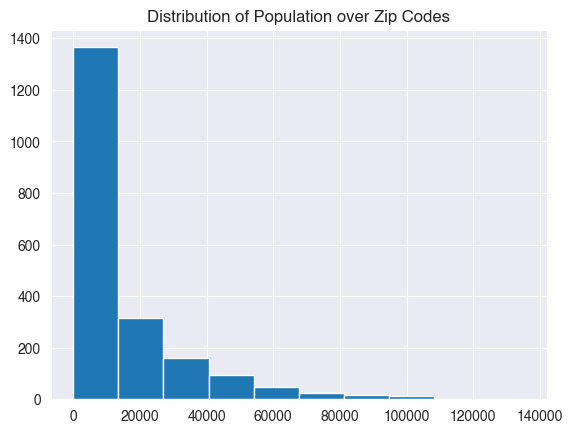

In [64]:
print("Median ZIP Code Population in Data Set:", df_tri['Population'].median())
df_tri['Population'].hist().set(Title='Distribution of Population over Zip Codes');

In [65]:
pops = df_tri['Population']
high_pop = []

for pop in pops:
    if pop >= 10000:
        high_pop.append(1)
    else:
        high_pop.append(0)

df_tri['high_pop'] = high_pop

### Creating County-Level Voting Column
Data Source: https://www.kaggle.com/datasets/unanimad/us-election-2020?resource=download&select=president_county_candidate.csv

In [66]:
# Adding column to main dataframe to merge with election data
zips = df_tri['ZIP Code']
counties = []

for code in zips:
    county = zipcodes.matching(code)[0]['county']
    counties.append(county)
    

df_tri['County'] = counties

In [67]:
df_pol = pd.read_csv('2020 Election Results by County.csv')
df_pol

,state,county,candidate,party,total_votes,won
0,Delaware,Kent County,Joe Biden,DEM,44552,True
1,Delaware,Kent County,Donald Trump,REP,41009,False
2,Delaware,Kent County,Jo Jorgensen,LIB,1044,False
3,Delaware,Kent County,Howie Hawkins,GRN,420,False
4,Delaware,New Castle County,Joe Biden,DEM,195034,True
...,...,...,...,...,...,...
32172,Arizona,Maricopa County,Write-ins,WRI,1331,False
32173,Arizona,Mohave County,Donald Trump,REP,78535,True
32174,Arizona,Mohave County,Joe Biden,DEM,24831,False
32175,Arizona,Mohave County,Jo Jorgensen,LIB,1302,False


In [68]:
# Limiting dataframe to only values for NY, NJ, and CT
df_pol = df_pol.loc[(df_pol['state'] == 'New York') | (df_pol['state'] == 'New Jersey') | 
                    (df_pol['state'] == 'Connecticut'), :]

In [69]:
# Limiting dataframe to only value votes for Joe Biden
df_pol = df_pol.loc[(df_pol['candidate'] == 'Joe Biden')]

In [70]:
df_pol = df_pol[['county', 'won']]

In [71]:
# There are repeat counties in NJ and NY - luckily, they both voted the same so I am aggregating them below
df_pol = df_pol.groupby(['county']).mean()

In [72]:
df_pol = df_pol.reset_index()

In [73]:
df_pol = df_pol.rename(columns={'county': 'County', 'won': 'voted for joe'})

In [74]:
df_tri = df_tri.merge(df_pol, on='County', how='left')

In [75]:
# Filling NaNs with 1 as Connecticut looks to have many missing values and is a majority Dem state
df_tri = df_tri.fillna(1)

### Adding in EV Chargers in Area


In [76]:
df_charge = pd.read_csv('alt_fuel_stations (Jul 29 2021).csv')

In [77]:
df_charge = df_charge.loc[(df_charge['State'] == 'NY') | (df_charge['State'] == 'NJ') | 
                    (df_charge['State'] == 'CT'), :]

In [78]:
df_charge = df_charge.loc[(df_charge['Fuel Type Code'] == 'ELEC')]

In [79]:
df_charge = df_charge[['ZIP', 'Fuel Type Code']]

In [80]:
df_charge = df_charge.rename(columns={'Fuel Type Code': 'EV Charging Stations'})

In [81]:
df_charge = df_charge.groupby(['ZIP']).count()

In [82]:
df_charge = df_charge.reset_index()

In [83]:
df_charge.head()

,ZIP,EV Charging Stations
0,6001,1
1,6002,4
2,6010,1
3,6013,1
4,6018,1


In [84]:
df_charge['ZIP'] = df_charge['ZIP'].astype(str)

zips = df_charge['ZIP']
new_zips = []

for code in zips:
    if len(code) < 5:
        new_code = '0' + code
        new_zips.append(new_code)
    else:
        new_zips.append(code)
        
df_charge['ZIP Code'] = new_zips
df_charge = df_charge.drop(columns='ZIP')

In [85]:
df_charge.head()

,EV Charging Stations,ZIP Code
0,1,06001
1,4,06002
2,1,06010
3,1,06013
4,1,06018


In [86]:
df_tri = df_tri.merge(df_charge, on='ZIP Code', how='left')

In [87]:
df_tri['EV Charging Stations'] = df_tri['EV Charging Stations'].fillna(0)

### Adding in Age and Sex Data

In [88]:
df_age = pd.read_csv('Age Data/ACSST5Y2021.S0101-Data.csv')

In [89]:
# Limiting DF to relevant columns
df_age = df_age[['NAME', 'S0101_C02_007E', 'S0101_C02_008E', 'S0101_C02_009E']]

In [90]:
# Dropping first row which includes meta data
df_age = df_age.drop(index=0)

In [91]:
# renaming columns per data dictionary - making education columns more readable
df_age = df_age.rename(columns={'NAME': 'ZIP Code', 'S0101_C02_007E': 'Percent Pop. Age 25-29',
                               'S0101_C02_008E': 'Percent Pop. Age 30-34',
                               'S0101_C02_009E': 'Percent Pop. Age 35-39'})

In [92]:
# dropping unwanted strings and rows from zip code
df_age['ZIP Code'] = df_age['ZIP Code'].str.replace(r'ZCTA5 ', '', regex=True)
df_age = df_age[df_age['Percent Pop. Age 25-29'].str.contains('-')==False]

In [93]:
df_age.head()

,ZIP Code,Percent Pop. Age 25-29,Percent Pop. Age 30-34,Percent Pop. Age 35-39
1,06001,2.8,4.4,4.9
2,06002,5.0,7.4,5.6
3,06010,6.7,6.3,7.7
4,06013,4.0,4.3,8.2
5,06016,8.1,9.0,6.5


In [94]:
# Changing type of Educational Attainment Columns
df_age['Percent Pop. Age 25-29'] = df_age['Percent Pop. Age 25-29'].astype('float')
df_age['Percent Pop. Age 30-34'] = df_age['Percent Pop. Age 30-34'].astype('float')
df_age['Percent Pop. Age 35-39'] = df_age['Percent Pop. Age 35-39'].astype('float')

In [95]:
df_tri = df_tri.merge(df_age, on='ZIP Code', how='left')

In [96]:
df_tri.head()

,ZIP Code,Vehicle Count,NY,NJ,Median Family Household Income,Population,Percent Pop. Bachelors Deg. - 35-44,Total Pop. Bachelors Deg. - 35-44,EVs per capita,in_NYC,dist_NYC,high_pop,County,voted for joe,EV Charging Stations,Percent Pop. Age 25-29,Percent Pop. Age 30-34,Percent Pop. Age 35-39
0,06390,4,1.0,0.0,46250.0,422.0,0.0,0.0,947.867299,0,178.284521,0,Suffolk County,0.0,0.0,0.0,12.1,10.3
1,07001,53,0.0,1.0,89079.0,16920.0,47.6,1093.0,313.238771,0,29.596334,1,Middlesex County,1.0,1.0,7.5,8.3,7.9
2,07002,181,0.0,1.0,84290.0,71686.0,46.8,4795.0,252.490026,0,13.642869,1,Hudson County,1.0,0.0,6.8,8.0,7.6
3,07003,290,0.0,1.0,105720.0,52955.0,58.4,4708.0,547.634784,0,16.559355,1,Essex County,1.0,7.0,8.2,7.7,8.4
4,07003,290,0.0,1.0,105720.0,52955.0,58.4,4708.0,547.634784,0,16.559355,1,Essex County,1.0,1.0,8.2,7.7,8.4


### Feature Engineering

In [97]:
df_tri.columns

Index(['ZIP Code', 'Vehicle Count', 'NY', 'NJ',
       'Median Family Household Income', 'Population',
       'Percent Pop. Bachelors Deg. - 35-44',
       'Total Pop. Bachelors Deg. - 35-44', 'EVs per capita', 'in_NYC',
       'dist_NYC', 'high_pop', 'County', 'voted for joe',
       'EV Charging Stations', 'Percent Pop. Age 25-29',
       'Percent Pop. Age 30-34', 'Percent Pop. Age 35-39'],
      dtype='object')

In [98]:
df_tri['Young_Liberal'] = df_tri['voted for joe']*df_tri['Percent Pop. Age 25-29']

In [99]:
df_tri['Income_Liberal'] = df_tri['voted for joe']*df_tri['Median Family Household Income']

In [100]:
df_tri['Income_Pop'] = df_tri['Median Family Household Income']*df_tri['Population']

In [101]:
df_tri['Ed_Income'] = df_tri['Total Pop. Bachelors Deg. - 35-44']*df_tri['Median Family Household Income']

In [102]:
incomes = df_tri['Median Family Household Income']
High_Income = []

for income in incomes:
    if income > 200000:
        High_Income.append(1)
    else:
        High_Income.append(0)

In [103]:
df_tri['High_Income'] = High_Income

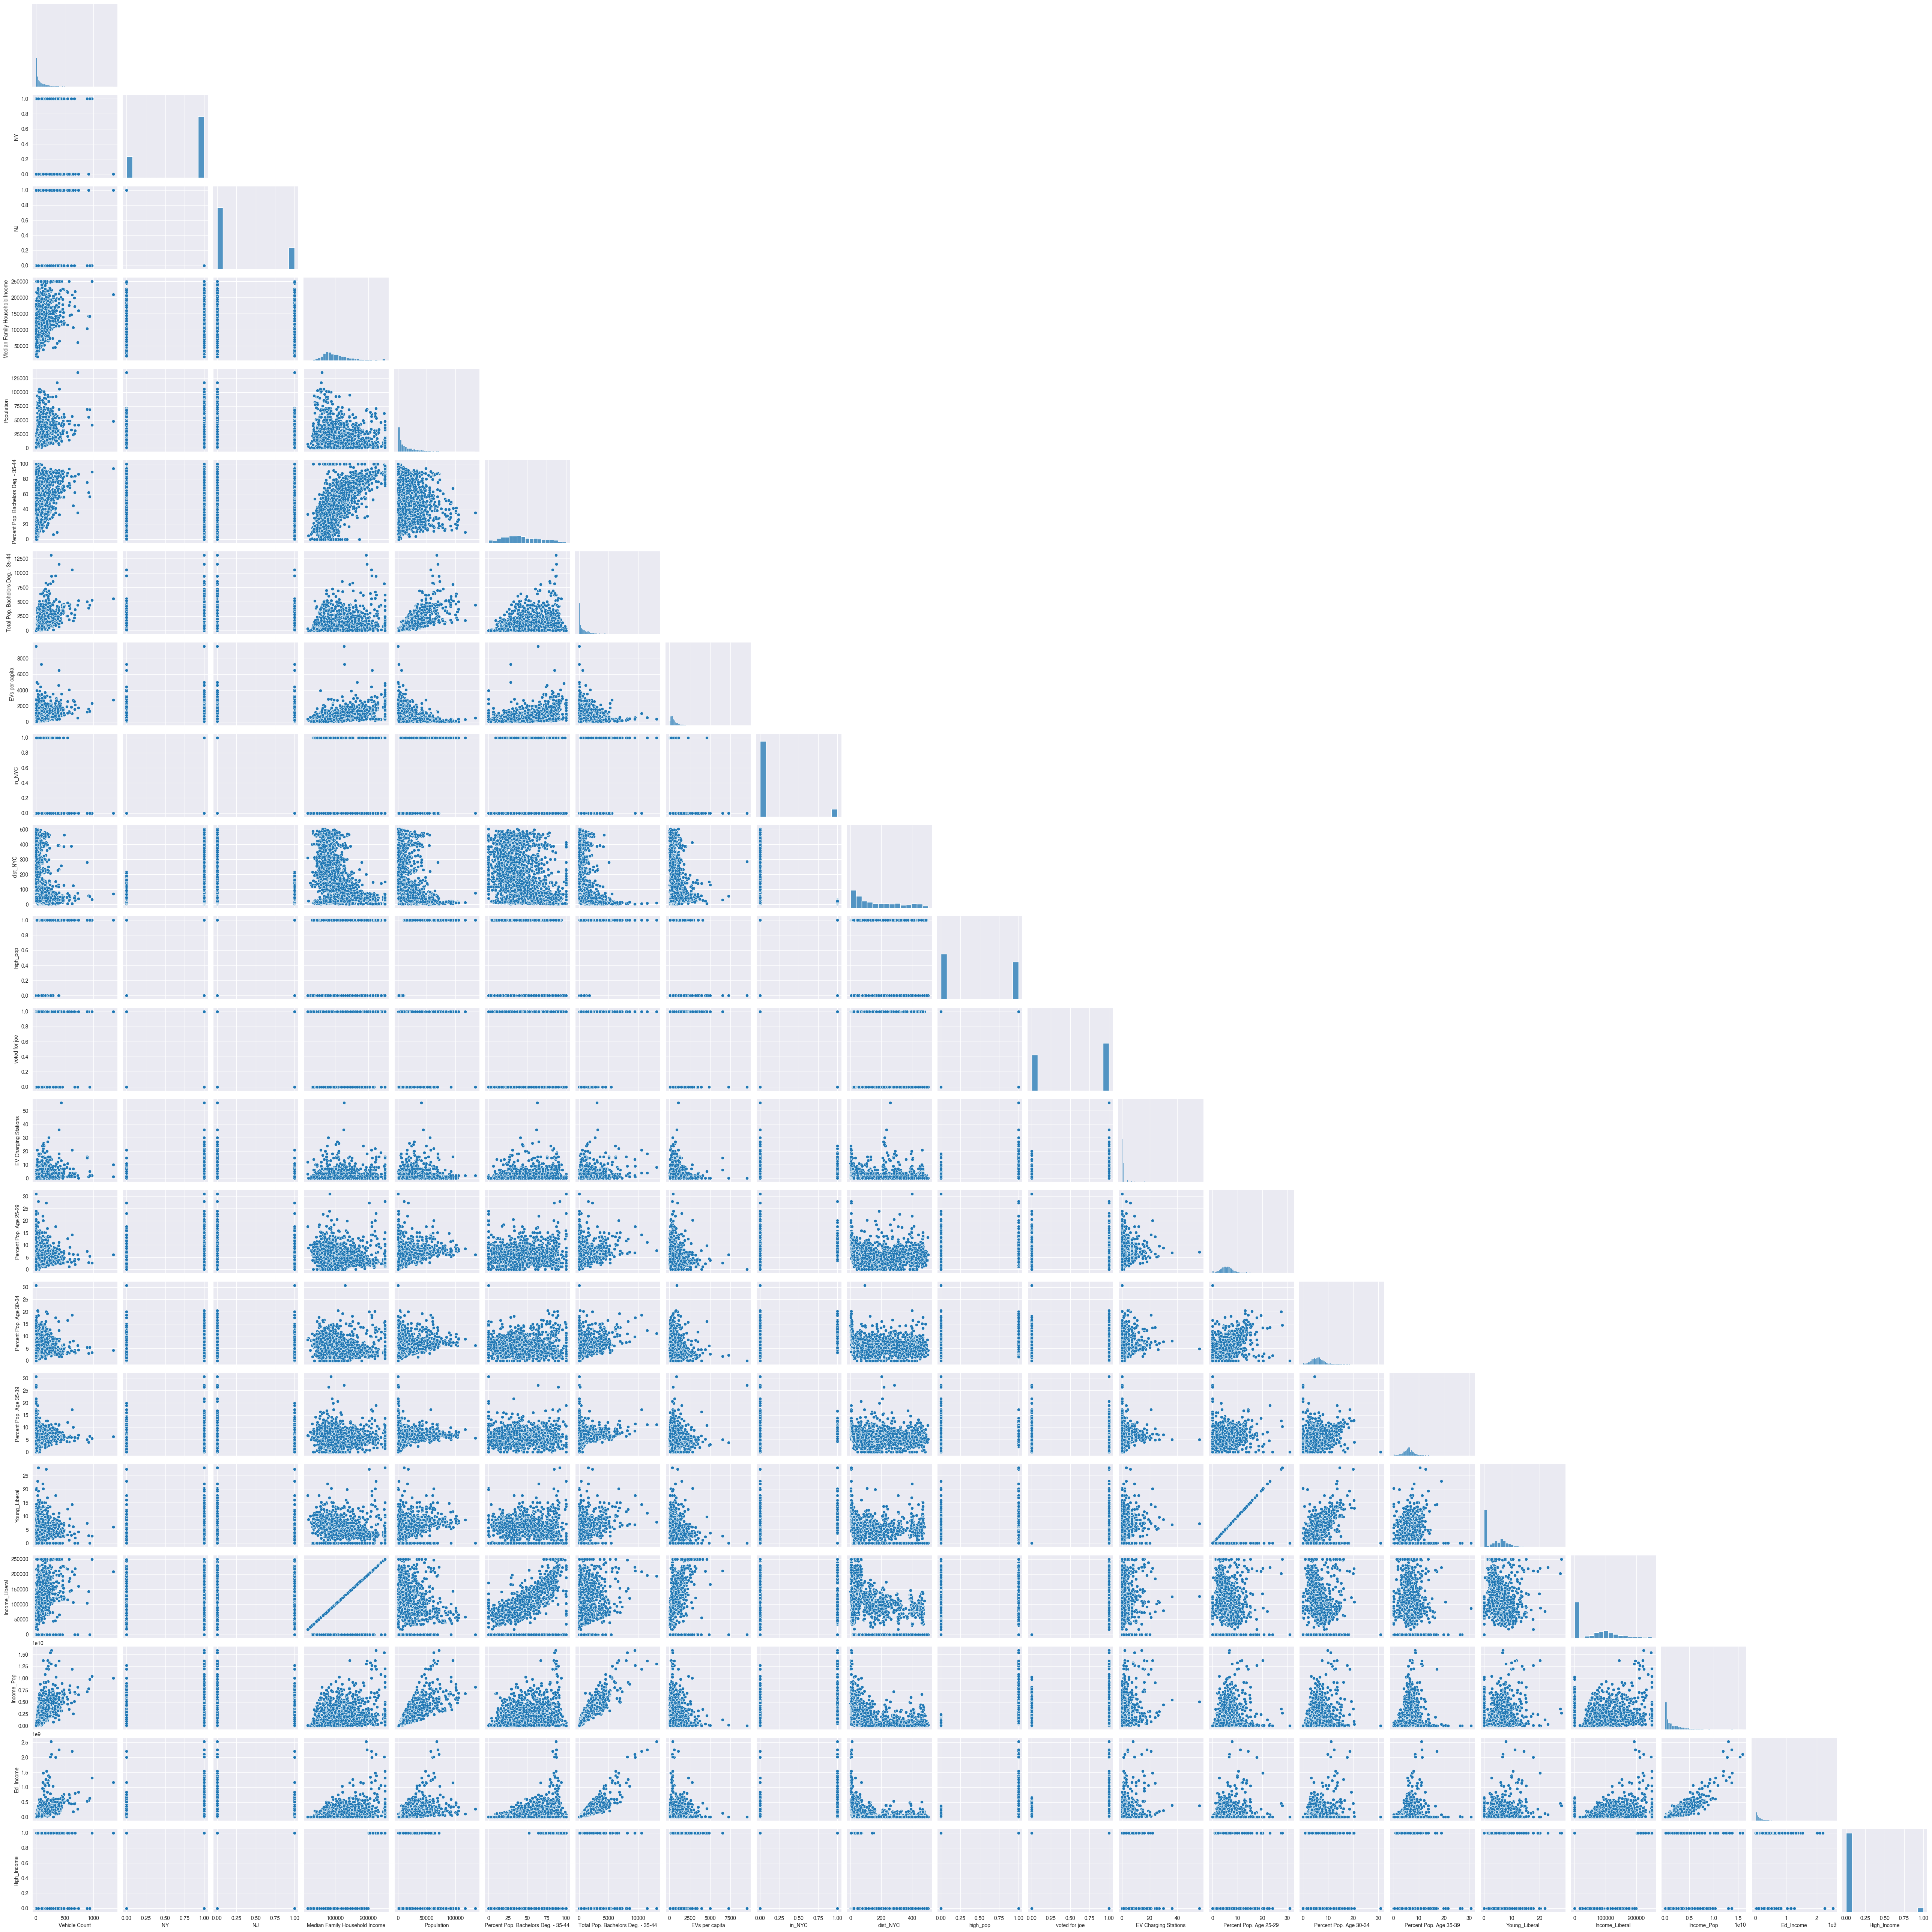

In [104]:
sns.pairplot(df_tri, corner=True);

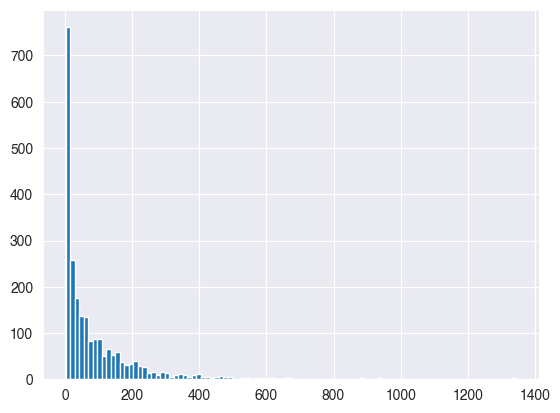

In [105]:
df_tri['Vehicle Count'].hist(bins=100);

In [106]:
df_tri['Vehicle Count'].std()

122.54766588446218

In [107]:
# Per the above, we are removing outliers in our data and giving a generous buffer of over 4 standard deviations
df_tri = df_tri.loc[(df_tri['Vehicle Count'] <= 750)]

# Models

### Testing Out A Rough Model - Linear Regression

In [108]:
import statsmodels.api as sm
import numpy as np

In [109]:
y = df_tri['Vehicle Count']
X = df_tri[['Median Family Household Income', 'Population', 'Percent Pop. Bachelors Deg. - 35-44', 
            'dist_NYC', 'high_pop', 'voted for joe', 'in_NYC', 'EV Charging Stations',
            'Percent Pop. Age 25-29', 'Percent Pop. Age 30-34', 'Percent Pop. Age 35-39', 'High_Income', 
           'Young_Liberal', 'Income_Liberal', 'Income_Pop', 'Ed_Income']]

In [110]:
model = sm.OLS(y, sm.add_constant(X))

In [111]:
results = model.fit()

In [112]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          Vehicle Count   R-squared:                       0.688
Model:                            OLS   Adj. R-squared:                  0.686
Method:                 Least Squares   F-statistic:                     317.7
Date:                Fri, 21 Jul 2023   Prob (F-statistic):               0.00
Time:                        14:25:05   Log-Likelihood:                -12853.
No. Observations:                2325   AIC:                         2.574e+04
Df Residuals:                    2308   BIC:                         2.584e+04
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
=======================================================================================================
                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
const                                 -45.2970     10.242     -4.423      0.000     -65.382     -25.212
Median Family Household Income          0.0004   7.78e-05      5.032      0.000       0.000       0.001
Population                              0.0010      0.000      4.532      0.000       0.001       0.001
Percent Pop. Bachelors Deg. - 35-44     0.5942      0.084      7.037      0.000       0.429       0.760
dist_NYC                                0.0097      0.012      0.831      0.406      -0.013       0.032
high_pop                               44.0249      3.949     11.148      0.000      36.281      51.769
voted for joe                           9.2501     10.251      0.902      0.367     -10.852      29.352
in_NYC                               -107.6366      5.877    -18.316      0.000    -119.161     -96.113
EV Charging Stations                    2.2678      0.449      5.055      0.000       1.388       3.148
Percent Pop. Age 25-29                 -0.5338      0.661     -0.807      0.420      -1.830       0.763
Percent Pop. Age 30-34                 -1.9897      0.524     -3.800      0.000      -3.017      -0.963
Percent Pop. Age 35-39                  0.8493      0.527      1.612      0.107      -0.184       1.882
High_Income                           -16.5103      8.160     -2.023      0.043     -32.513      -0.508
Young_Liberal                          -3.3847      0.894     -3.784      0.000      -5.139      -1.631
Income_Liberal                          0.0001   7.46e-05      1.369      0.171   -4.42e-05       0.000
Income_Pop                            2.35e-08   3.14e-09      7.488      0.000    1.73e-08    2.97e-08
Ed_Income                            1.235e-08   1.88e-08      0.656      0.512   -2.46e-08    4.92e-08
==============================================================================
Omnibus:                     1218.648   Durbin-Watson:                   1.280
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            16648.717
Skew:                           2.153   Prob(JB):                         0.00
Kurtosis:                      15.382   Cond. No.                     2.71e+10
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.71e+10. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Testing out a rough model - Categorical Regression


Median EVs per capita in Data Set: 440.72278536800354


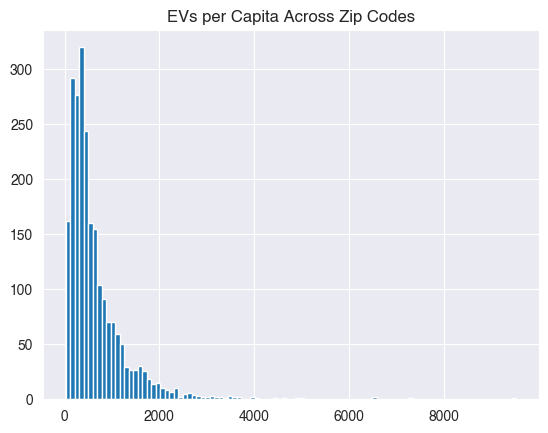

In [113]:
print("Median EVs per capita in Data Set:", df_tri['EVs per capita'].median())
df_tri['EVs per capita'].hist(bins=100).set(Title='EVs per Capita Across Zip Codes');

In [114]:
df_tri['EVs per capita'].std()

660.596362993508

In [115]:
# Creating new variable indicating if zip code has high number of EVs per capita
EVs_capita = df_tri['EVs per capita']
high_EVs = []

for EVs in EVs_capita:
    if EVs >= 1500:
        high_EVs.append(2)
    elif EVs >= 440:
        high_EVs.append(1)
    else:
        high_EVs.append(0)

df_tri['High EVs Per Capita'] = high_EVs

In [118]:
y = df_tri['High EVs Per Capita']
X = df_tri[['Median Family Household Income', 'Population', 'Percent Pop. Bachelors Deg. - 35-44', 
            'dist_NYC', 'high_pop', 'voted for joe', 'in_NYC', 'EV Charging Stations', 'NY', 'High_Income', 
           'Young_Liberal', 'Income_Liberal', 'Income_Pop', 'Ed_Income']]

In [119]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=42)

In [120]:
# NOTE: MAYBE USE SMOTE HERE?

**Logistic Regression**

In [121]:
# Build a pipeline with StandardScaler and Logistic Regression
scaled_pipeline_1 = Pipeline([('scaler', StandardScaler()), ('logreg', LogisticRegression(random_state = 42))])

In [122]:
# Fit the training data to pipeline
scaled_pipeline_1.fit(X_train, y_train)

# Print the accuracy on training and test sets
print("Accuracy Score of Training Data:", scaled_pipeline_1.score(X_train, y_train))
print("Accuracy Score of Test Data:", scaled_pipeline_1.score(X_test, y_test))

Accuracy Score of Training Data: 0.7627535341118623
Accuracy Score of Test Data: 0.7521489971346705


**Random Forest Classifier**

In [123]:
# Build a pipeline with StandardScaler and RandomForestClassifier
scaled_pipeline_2 = Pipeline([('scaler', StandardScaler()), ('RF', RandomForestClassifier(random_state = 42))])

In [124]:
# Fit the training data to pipeline
scaled_pipeline_2.fit(X_train, y_train)

# Print the accuracy on test set
print("Accuracy Score of Training Data:", scaled_pipeline_2.score(X_train, y_train))
print("Accuracy Score of Test Data:", scaled_pipeline_2.score(X_test, y_test))

Accuracy Score of Training Data: 1.0
Accuracy Score of Test Data: 0.8123209169054442


**Gridsearch**

In [125]:
# Define the grid
grid = [{'RF__max_depth': [2, 6, 8, 10], 
         'RF__min_samples_split': [2, 3], 
         'RF__min_samples_leaf': [3, 5]}]

In [126]:
# Define a grid search
gridsearch = GridSearchCV(estimator = scaled_pipeline_2, param_grid = grid, scoring = 'accuracy', cv = 5)

In [127]:
# Fit the training data
gridsearch.fit(X_train, y_train)

# Printing the Best Parameters for our Model
best_params = gridsearch.best_params_
print(best_params)

{'RF__max_depth': 10, 'RF__min_samples_leaf': 5, 'RF__min_samples_split': 2}


In [128]:
# Print the accuracy on training and test sets
print("Accuracy Score of Training Data:", gridsearch.score(X_train, y_train))
print("Accuracy Score of Test Data:", gridsearch.score(X_test, y_test))

Accuracy Score of Training Data: 0.8635525507068224
Accuracy Score of Test Data: 0.7808022922636103


In [129]:
# Finding Feature Importance from Our Random Forest Model
importances = scaled_pipeline_2.named_steps['RF'].feature_importances_

# Creating List of Tuples with Feature Names and Importances
feature_importances = [(feature, importance) for feature, importance in zip(X.columns, importances)]
feature_importances

[('Median Family Household Income', 0.21997204686973743),
 ('Population', 0.0918636205764161),
 ('Percent Pop. Bachelors Deg. - 35-44', 0.15054101460083907),
 ('dist_NYC', 0.11185899251772176),
 ('high_pop', 0.007470642843019047),
 ('voted for joe', 0.008533539766854082),
 ('in_NYC', 0.019481040586930037),
 ('EV Charging Stations', 0.032801656799769624),
 ('NY', 0.01649230153905253),
 ('High_Income', 0.010919093636289942),
 ('Young_Liberal', 0.05419629246487664),
 ('Income_Liberal', 0.1017450807284095),
 ('Income_Pop', 0.08569271855216896),
 ('Ed_Income', 0.08843195851791523)]

In [132]:
df_tri = df_tri[['ZIP Code', 'Vehicle Count', 'EVs per capita']]

In [133]:
df_tri = df_tri.replace({'Vehicle Count': 'Vehicle Count_2022', 'EVs per capita': 'EVs per capita_2022'})

In [134]:
df_tri.to_csv('Cleaned_EV_Reg_Data_2022')